In [1]:
from google.colab import files
import zipfile, os

uploaded = files.upload()

# Extract
zip_path = next(iter(uploaded))
extract_path = '/content/Historical Product Demand.csv'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

Saving Historical Product Demand.csv.zip to Historical Product Demand.csv.zip
Extracted files: ['Historical Product Demand.csv']


**Importing Necessary Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

*Loading the data*

In [3]:
data = pd.read_csv("Historical Product Demand.csv.zip")
data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


*Getting some information about the dataset*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


 *A quick and insightful statistical summary*

In [5]:
data.describe().transpose()

,count,unique,top,freq
Product_Code,1048575,2160,Product_1359,16936
Warehouse,1048575,4,Whse_J,764447
Product_Category,1048575,33,Category_019,481099
Date,1037336,1729,2013/9/27,2075
Order_Demand,1048575,3828,1000,112682


*Duplicates are present in the dataset*

In [6]:
data[data.duplicated()==True]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
10,Product_0979,Whse_J,Category_028,2012/8/29,500
39,Product_1159,Whse_J,Category_006,2012/8/30,50000
51,Product_1157,Whse_J,Category_006,2012/3/8,150000
55,Product_1157,Whse_J,Category_006,2012/6/4,160000
67,Product_1274,Whse_J,Category_019,2012/1/24,1000
...,...,...,...,...,...
1048508,Product_1148,Whse_J,Category_006,2016/9/1,5000
1048521,Product_1391,Whse_J,Category_019,2016/6/3,100
1048531,Product_1391,Whse_J,Category_019,2016/8/22,100
1048568,Product_1759,Whse_J,Category_001,2016/8/17,1


*Dropping the Duplicates*

In [7]:
data = data.drop_duplicates()

*Missing values are also present in the dataset*

In [8]:
data.isnull().sum()

,0
Product_Code,0
Warehouse,0
Product_Category,0
Date,1880
Order_Demand,0


*Changing datetime object type*

In [9]:
data.loc[:,'Date'] = pd.to_datetime(data.loc[:,'Date'], format='%Y/%m/%d', errors='coerce')
data['Date']

,Date
0,2012-07-27 00:00:00
1,2012-01-19 00:00:00
2,2012-02-03 00:00:00
3,2012-02-09 00:00:00
4,2012-03-02 00:00:00
...,...
1048569,2016-11-10 00:00:00
1048571,2016-04-27 00:00:00
1048572,2016-04-28 00:00:00
1048573,2016-10-07 00:00:00


In [10]:
data.isnull().sum()

,0
Product_Code,0
Warehouse,0
Product_Category,0
Date,1880
Order_Demand,0


In [11]:
data.dropna(subset=['Date'],inplace=True)

*Filling the missing values present in Date*

In [12]:
start_date = pd.to_datetime('2012-01-01')
end_date = pd.to_datetime('2016-12-31')
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

In [13]:
data.isnull().sum()

,0
Product_Code,0
Warehouse,0
Product_Category,0
Date,0
Order_Demand,0


*Adding some columns like weekdays, years, weekends*

In [14]:
wkday = []
for i in range(len(data)):
    wkday.append(data['Date'].iloc[i].weekday())
yr = []
for i in range(len(data)):
    yr.append(data['Date'].iloc[i].year)

mon = []
for i in range(len(data)):
    mon.append(data['Date'].iloc[i].month)

In [15]:
data.loc[:, 'day'] = wkday
data.loc[:, 'year'] = yr
data.loc[:, 'month'] = mon

In [16]:
data.set_index('Date',inplace=True)

In [17]:
data.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,day,year,month
Date,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,4,2012,7
2012-01-19,Product_0979,Whse_J,Category_028,500,3,2012,1
2012-02-03,Product_0979,Whse_J,Category_028,500,4,2012,2
2012-02-09,Product_0979,Whse_J,Category_028,500,3,2012,2
2012-03-02,Product_0979,Whse_J,Category_028,500,4,2012,3


In [18]:
def weekend(day):
  if day == 5 or day == 6:
    return 1
  else:
    return 0

In [19]:
data.loc[:,'weekend'] = data['day'].apply(weekend)

In [20]:
data[data['weekend']==1].head()

,Product_Code,Warehouse,Product_Category,Order_Demand,day,year,month,weekend
Date,,,,,,,,
2012-08-25,Product_1241,Whse_S,Category_019,30000,5,2012,8,1
2012-08-25,Product_1570,Whse_S,Category_019,90000,5,2012,8,1
2012-08-25,Product_1904,Whse_S,Category_019,100000,5,2012,8,1
2012-11-04,Product_1241,Whse_S,Category_019,100000,6,2012,11,1
2012-11-04,Product_1570,Whse_S,Category_019,85000,6,2012,11,1


In [21]:
data.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Order_Demand', 'day',
       'year', 'month', 'weekend'],
      dtype='object')

In [22]:
data['Warehouse'].value_counts().sort_values(ascending=False)

,count
Warehouse,
Whse_J,665388
Whse_A,130618
Whse_S,86042
Whse_C,41559


*Extracting rows corresponding to Warehouse J*

In [23]:
dataJ = data[data['Warehouse']== 'Whse_J']

In [24]:
dataJ.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,day,year,month,weekend
Date,,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,4,2012,7,0
2012-01-19,Product_0979,Whse_J,Category_028,500,3,2012,1,0
2012-02-03,Product_0979,Whse_J,Category_028,500,4,2012,2,0
2012-02-09,Product_0979,Whse_J,Category_028,500,3,2012,2,0
2012-03-02,Product_0979,Whse_J,Category_028,500,4,2012,3,0


*Grouping the data by Date, Product_Category, Warehouse and Order_Demand*

In [25]:
tdata = data.groupby(['Date', 'Product_Category', 'Warehouse'])['Order_Demand'].sum().reset_index()

In [26]:
tdata.head()

,Date,Product_Category,Warehouse,Order_Demand
0,2012-01-01,Category_024,Whse_S,2
1,2012-01-02,Category_001,Whse_S,4 3 100
2,2012-01-02,Category_005,Whse_S,2000 500 1000
3,2012-01-02,Category_006,Whse_S,8000 2500 2500
4,2012-01-02,Category_011,Whse_S,5 20


*Displaying the Warehouse with minimum Order Demand*

In [27]:
min_order_demand = tdata.loc[tdata['Order_Demand'].idxmin()]

min_warehouse = min_order_demand['Warehouse']
print(f"Warehouse with minimum Order_Demand: {min_warehouse}")

Warehouse with minimum Order_Demand: Whse_J


*Displaying the Warehouse with maximum Order Demand*

In [28]:
max_order_demand = tdata.loc[tdata['Order_Demand'].idxmax()]

max_warehouse = max_order_demand['Warehouse']
print(f"Warehouse with maximum Order_Demand: {max_warehouse}")

Warehouse with maximum Order_Demand: Whse_S


*Category19 has a lot of orders*

33


<Axes: xlabel='count', ylabel='Product_Category'>

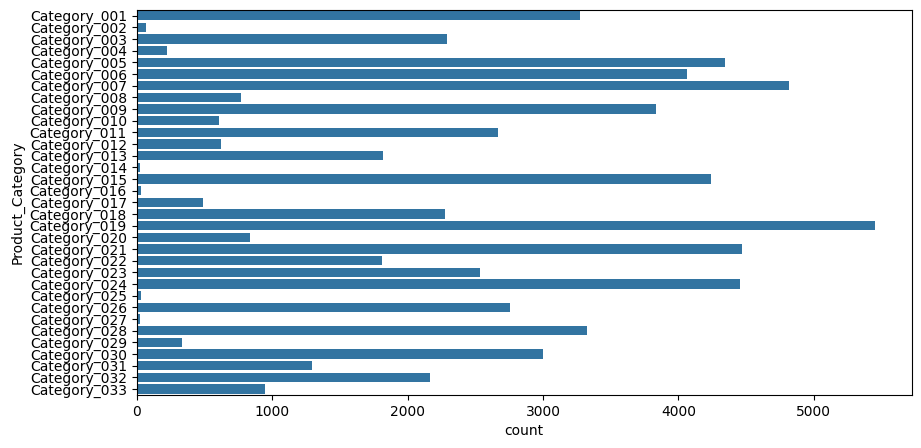

In [29]:
print (len(tdata['Product_Category'].value_counts()))

sns.countplot(tdata['Product_Category'].sort_values(ascending = True))

In [30]:
data['Order_Demand'] = pd.to_numeric(data['Order_Demand'],errors='coerce')

*Converting Categorical Variables into Numerical Variables*

In [31]:
le = LabelEncoder()

data['Product_Code'] = le.fit_transform(data['Product_Code'])
data['Warehouse'] = le.fit_transform(data['Warehouse'])
data['Product_Category'] = le.fit_transform(data['Product_Category'])

In [32]:
data.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,day,year,month,weekend
Date,,,,,,,,
2012-07-27,982,2,27,100.0,4,2012,7,0
2012-01-19,968,2,27,500.0,3,2012,1,0
2012-02-03,968,2,27,500.0,4,2012,2,0
2012-02-09,968,2,27,500.0,3,2012,2,0
2012-03-02,968,2,27,500.0,4,2012,3,0


*Plotting the Monthly Order Demand Trend Over the Years*

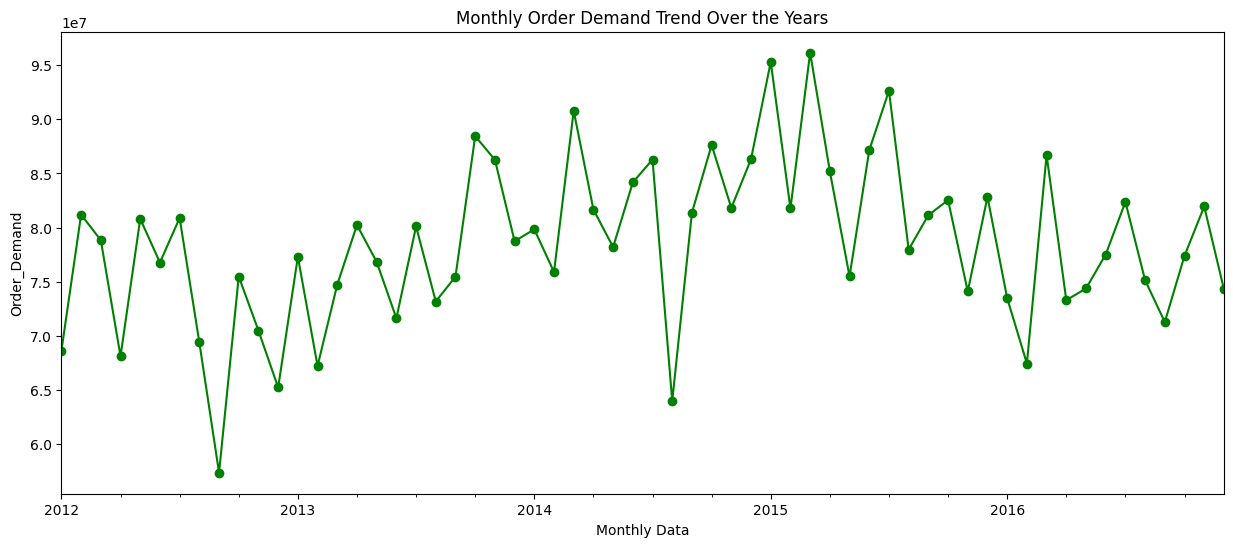

In [33]:
monthly_data = data['Order_Demand'].resample('M').sum()

plt.figure(figsize=(15,6))
monthly_data.plot(kind='line', marker='o',c='green')
plt.title('Monthly Order Demand Trend Over the Years')
plt.xlabel('Monthly Data')
plt.ylabel('Order_Demand')
plt.show()

*Plotting the Weekly Order Demand Trend Over Time*
* Weekly data illustrates the seasonality much better than monthly data, but  we'll work with monthly data because handling large lag values in weekly data is difficult

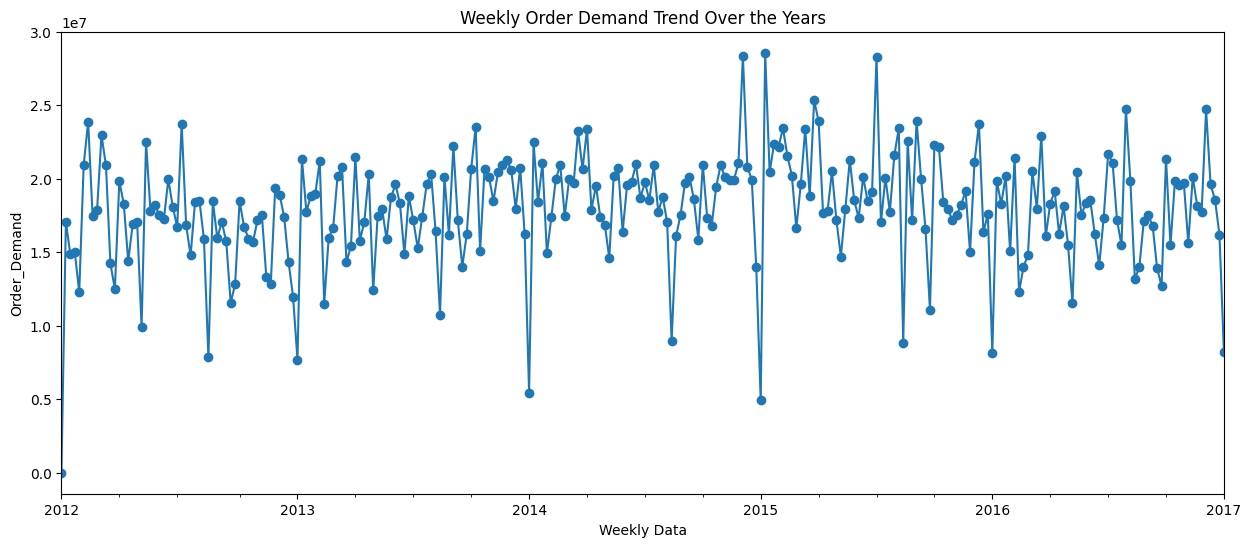

In [34]:
w_data = data['Order_Demand'].resample('W').sum()

plt.figure(figsize=(15,6))
w_data.plot(kind='line', marker='o')
plt.title('Weekly Order Demand Trend Over the Years')
plt.xlabel('Weekly Data')
plt.ylabel('Order_Demand')
plt.show()

*Perform the Augmented Dickey-Fuller test to check for stationarity*

In [35]:
result = adfuller(monthly_data)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Based on p-value determining stationarity
if result[1] < 0.05:
    print("Stationary.")
else:
    print("Non-stationary.")

ADF Statistic: -2.112796
p-value: 0.239401
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
Non-stationary.


*Plotting ACF and PACF of the monthly data of the Order Demand*                         
Understanding ACF and PACF as it is vital for analyzing time series data.

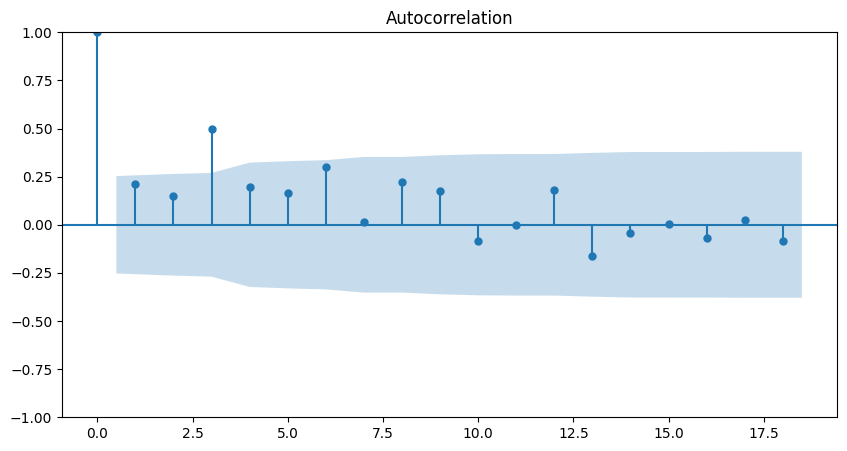

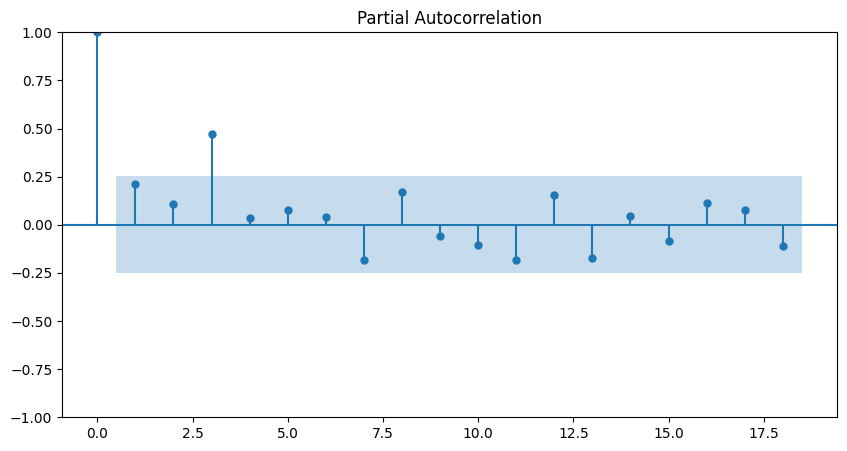

In [36]:
plot_acf(monthly_data)
plot_pacf(monthly_data)
plt.show()

*Plotting autocorrelation of monthly order demand trend*
* Additional insights into the data.
* Helps validate the results obtained from the plots.
* Identifying non-stationarity, determining optimal lag, and refining the forecasting model.


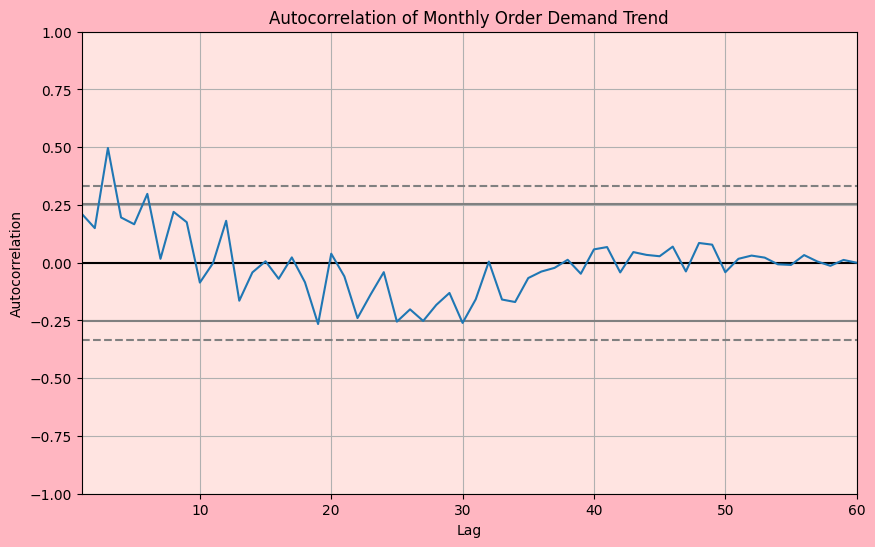

In [37]:
plt.figure(figsize=(10, 6), facecolor='lightpink')
autocorrelation_plot(monthly_data)
plt.gca().set_facecolor('mistyrose')
plt.title('Autocorrelation of Monthly Order Demand Trend')
plt.show()

*Using Classical time series decomposition*                                   
* Using to decompose a time series into its fundamental components.           

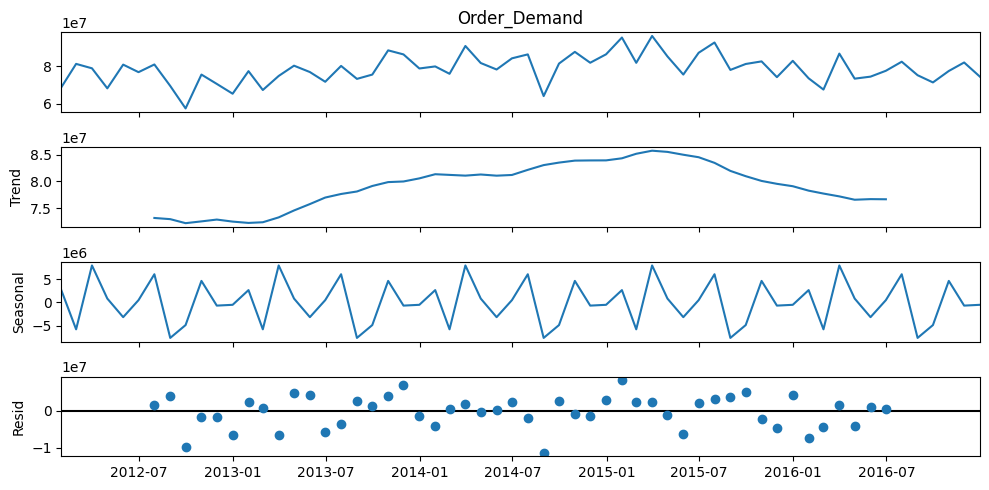

In [38]:
decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive')

fig = decomposition.plot()
plt.show()

*Deseasonalising data to visually estimate p, q , r which are essential parameters in time series modeling.*
* Involves removing the seasonal component from the time series.

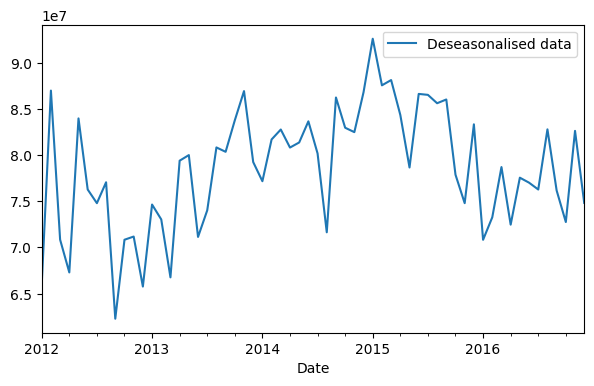

In [39]:
seasonal = decomposition.seasonal
deseasonalised_data = monthly_data - seasonal
deseasonalised_data.plot(figsize=(7,4), label = 'Deseasonalised data')
plt.legend()
plt.show()

*Determining d*

* Differenced the time series data to make it stationary. Stationarity, meaning that the statistical properties of the data (mean, variance, autocorrelation) do not change over time, is essential for accurate forecasting and analysis.    
* Differencing helps achieve stationarity by removing trends and seasonality, which are common sources of non-stationarity.                                  
* Using the ADF test to determine how many degrees of differencing is sufficient to make it stationary, making it suitable for further analysis and modeling
* d=1 as first order differencing is sufficient to make the series stationary.

adf:-12.624649976147643
pvalue:1.551140503550728e-23


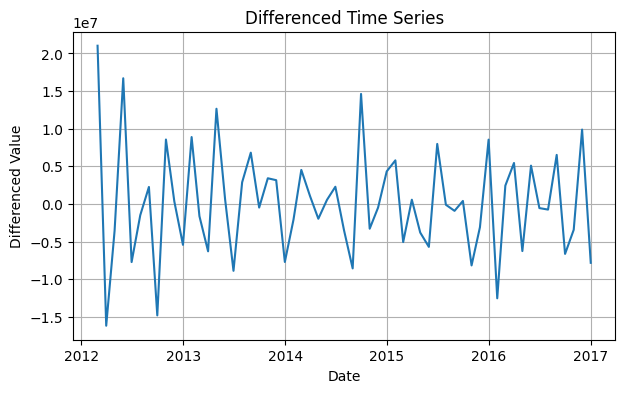

In [40]:
first_order_diff = deseasonalised_data.diff()
adf, pvalue, _,_,_,_=adfuller(first_order_diff.dropna())

print(f'adf:{adf}')
print(f'pvalue:{pvalue}')

plt.figure(figsize=(7, 4))
plt.plot(first_order_diff.dropna())
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.grid(True)
plt.show()

*Determining q*

*Determined q = 3 by visualizing ACF*

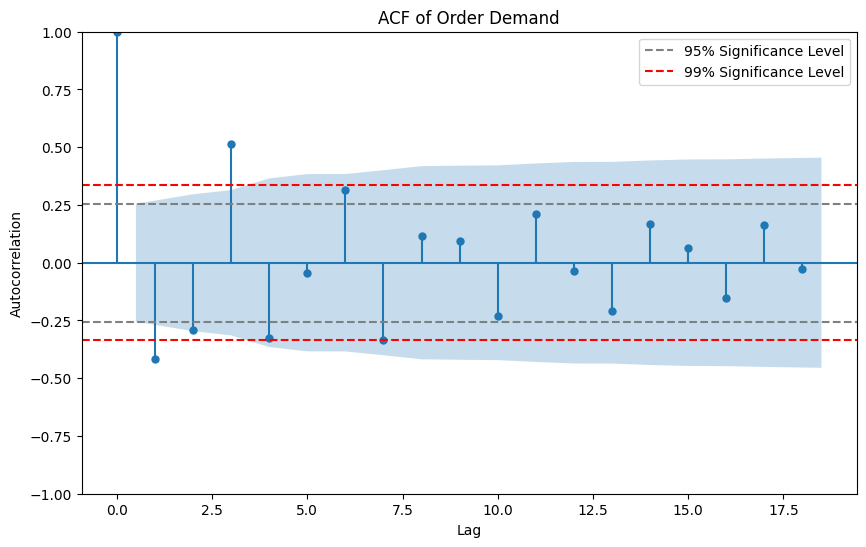

In [41]:
first_order_diff = first_order_diff.dropna()
crit_val_95 = 1.96 / (len(first_order_diff)**0.5)  # For 95% confidence interval
crit_val_99 = 2.58 / (len(first_order_diff)**0.5)  # For 99% confidence interval

fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(first_order_diff, ax=ax, alpha=0.05)

ax.axhline(y=crit_val_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-crit_val_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=crit_val_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-crit_val_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Order Demand')
plt.legend()
plt.show()

*DETERMINING p*

*Determined p = 3 by visualizing PACF*

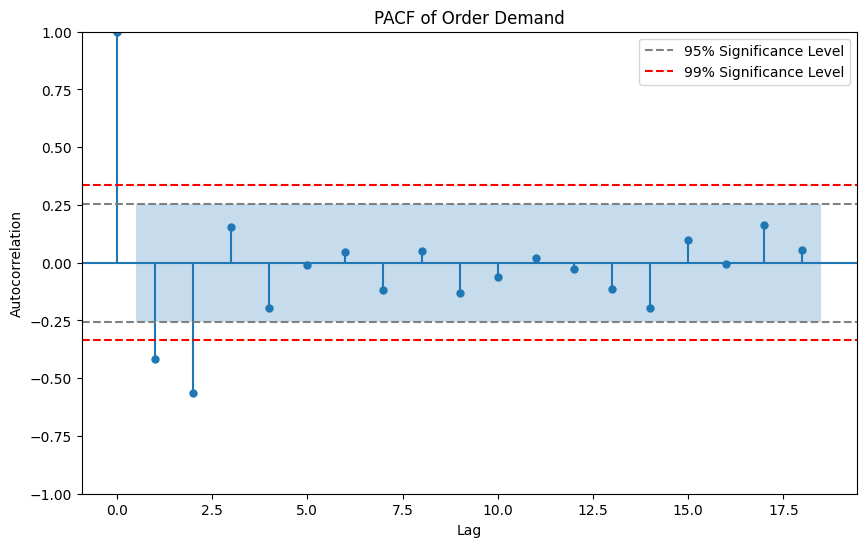

In [42]:
crit_val_95 = 1.96 / (len(first_order_diff)**0.5)  # For 95% confidence interval
crit_val_99 = 2.58 / (len(first_order_diff)**0.5)  # For 99% confidence interval

fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(first_order_diff, ax=ax)

ax.axhline(y=crit_val_95, linestyle='--', color='gray', linewidth=1.5, label='95% Significance Level')
ax.axhline(y=-crit_val_95, linestyle='--', color='gray', linewidth=1.5)
ax.axhline(y=crit_val_99, linestyle='--', color='red', linewidth=1.5, label='99% Significance Level')
ax.axhline(y=-crit_val_99, linestyle='--', color='red', linewidth=1.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('PACF of Order Demand')
plt.legend()
plt.show()

**Model Selection - SARIMA**

* Using Grid Search for parameter tuning
* Trying all combinations within this range to find the best parameters for this model  

In [43]:
# Defining the ranges for the parameters
d = range(1, 2)
p = range(0, 4)
q = range(0, 4)
P = D = Q = range(0, 2)

# Generating all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

# Performing grid search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(monthly_data, order=param, seasonal_order=param_seasonal,
                           enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            # If there's an error, continue to the next parameter combination
            print(f"Error for SARIMA{param}x{param_seasonal}: {str(e)}")
            continue

SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2028.58767760211
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1599.9717795304825
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1608.1163517910684
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:3268.8780178653733
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1632.654922007457
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1599.2608557984552
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1221.8671165489352
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:3266.9491351912075
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1964.8692844325208
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1549.5820438449957
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1561.4926491991375
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3181.4372122615264
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1617.943620807633
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1548.8996804680755
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1213.8385569997072
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3178.6044908218482
SARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:1931.2905147130919
SARIMA(0, 1, 2)x(0, 0, 1, 12)12 - A

*Best parameters are SARIMA(3, 1, 0)x(1, 1, 0, 12)12 - AIC:1105.1127017725232*

In [44]:
model = SARIMAX(monthly_data,
                order=(3, 1, 0),
                seasonal_order=(1, 1, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   60
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -547.556
Date:                            Thu, 21 Aug 2025   AIC                           1105.113
Time:                                    21:19:05   BIC                           1112.441
Sample:                                01-31-2012   HQIC                          1107.542
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5574      0.227     -2.451      0.014      -1.003      -0.112
ar.L2         -0.4232      0.257   

*Forecasting future demand*

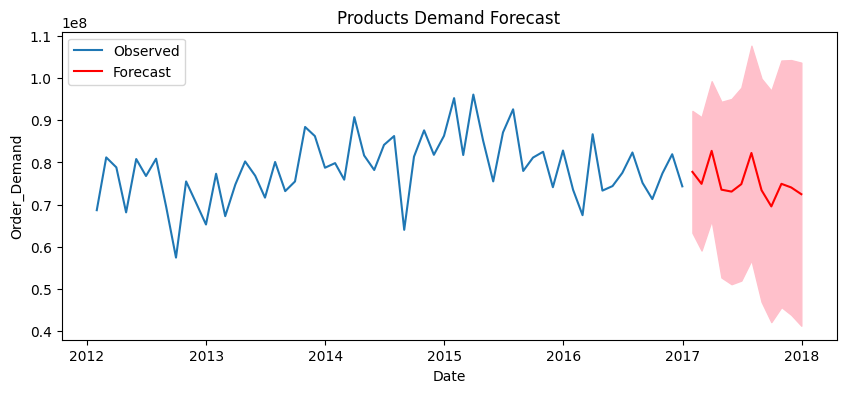

In [45]:
forecast_periods = 12  # Forecasting the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 4))
plt.plot(monthly_data, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Products Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Order_Demand")
plt.legend()
plt.show()